In [1]:
!pip install mlflow

     |████████████████████████████████| 10.4MB 4.8MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 460kB 47.1MB/s 
     |████████████████████████████████| 6.0MB 36.7MB/s 
     |████████████████████████████████| 1.1MB 44.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 92kB 9.3MB/s 
     |████████████████████████████████| 153kB 46.2MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 204kB 49.3MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=3bf1bfd34070c690c3450a457d45339a4f0fbaa275e97704b56fa37d665d3e60
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Success

In [2]:
import pandas as pd
import numpy as np
from datetime  import datetime  
from datetime import timedelta  
import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.lightgbm
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
np.random.seed(0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_folder = '/content/drive/My Drive/Kaggle_M5/00_data/'
submission = pd.read_csv(data_folder + 'sample_submission.csv')

In [0]:
params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective':  'tweedie',
        'n_jobs': -1,
        'seed': 0,
        'learning_rate': 0.05, 
        'bagging_fraction': 0.9,
        'bagging_freq': 1, 
        'colsample_bytree': 0.75,
        'num_iterations': 5000,
        'early_stopping_round': 500,
        'max_bin': 100,
        'boost_from_average': False}

In [0]:
params = {'bagging_fraction': 0.5, 
          'bagging_freq': 10, 
          'boosting_type': 'gbdt', 
          'colsample_bytree': 0.75, 
          'early_stopping_round': 500, 
          'learning_rate': 0.05, 
          'metric': 'rmse', 
          'n_jobs': -1, 
          'num_iterations': 5000, 
          'early_stopping_round': 500,         
          'objective': 'tweedie', 
          'seed': 0}

In [0]:
params = {'bagging_fraction': 0.75, 
          'bagging_freq': 5, 
          'boosting_type': 'gbdt', 
          'colsample_bytree': 0.75, 
          'early_stopping_round': 500, 
          'learning_rate': 0.05, 
          'metric': 'rmse', 
          'n_jobs': -1, 
          'num_iterations': 5000, 
          'objective': 'poisson', 
          'seed': 0}

In [0]:
evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation_rows = [row for row in submission['id'] if 'validation' in row] 
validation_csv = submission[submission['id'].isin(validation_rows)]


In [0]:
not_features = ['d', 'id', 'item_id', 'store_id', 'dept_id', 'demand', 'date', 'state_id',
                'start_date',
                'demand_type', 
                'snap_CA', 	'snap_TX', 	'snap_WI', 'cheaper_than_usual']

In [11]:
data_folder = '/content/drive/My Drive/Kaggle_M5/01_preprocessed_data/'

X_val = pd.read_pickle(data_folder + "X_val_CA_1.pkl")
X_val

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,weekday,month,event_name_1,event_type_1,year,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,start_date,days_from_start,start_date_from_start,sell_price,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,rmean_28_3,rmean_28_7,ADI,CV2,demand_type,"demand__agg_autocorrelation__f_agg_""mean""__maxlag_40","demand__agg_autocorrelation__f_agg_""median""__maxlag_40","demand__agg_autocorrelation__f_agg_""var""__maxlag_40",demand__ar_coefficient__k_10__coeff_3,avg_price,avg_demand,max_demand,std_demand,non_zero_seq_len,zero_seq_len,avg_weekday_demand,quantile025_week,max_weekday_demand,cheaper_than_usual
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1886,1,2016-03-28,Monday,3,no event,no event,2016,no event,no event,0,0,0,2013-07-13,1885,896,8.257812,0.0,2.0,4.0,1.0,0.0,1.0,0.0,4.0,2.000000,1.142578,2.408203,0.266357,intermittent,0.009262,-0.000309,0.001392,-0.008186,8.257812,0.588867,5,0.844238,9,34,0.536621,0.0,4,False
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1886,1,2016-03-28,Monday,3,no event,no event,2016,no event,no event,0,0,0,2011-06-18,1885,140,3.970703,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.142822,4.351562,0.238159,intermittent,0.047943,0.040588,0.002195,0.019684,3.970703,0.282959,5,0.593262,7,30,0.229492,0.0,3,False
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1886,0,2016-03-28,Monday,3,no event,no event,2016,no event,no event,0,0,0,2014-02-01,1885,1099,2.970703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3.890625,0.304688,intermittent,0.029526,0.023270,0.000718,0.021149,2.970703,0.343506,6,0.694336,10,77,0.261719,0.0,2,False
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1886,0,2016-03-28,Monday,3,no event,no event,2016,no event,no event,0,0,0,2011-03-05,1885,35,4.640625,0.0,6.0,0.0,3.0,2.0,1.0,1.0,2.0,2.000000,1.857422,1.435547,0.586914,lumpy,0.013237,-0.016266,0.019897,0.006306,4.527344,1.773438,15,2.005859,28,42,1.428711,0.0,9,False
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1886,1,2016-03-28,Monday,3,no event,no event,2016,no event,no event,0,0,0,2011-05-21,1885,112,2.880859,1.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,1.000000,1.000000,1.888672,0.393311,intermittent,0.055328,0.039795,0.002975,0.021820,2.943359,1.005859,9,1.286133,11,49,0.834473,0.0,7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826274,FOODS_3_823_CA_1_validation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,d_1913,1,2016-04-24,Sunday,4,no event,no event,2016,no event,no event,0,0,0,2012-08-04,1912,553,2.980469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.783203,0.447266,intermittent,0.159546,0.119568,0.014542,0.013779,2.744141,0.774902,10,1.348633,24,389,1.139648,0.0,10,False
826275,FOODS_3_824_CA_1_validation,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,d_1913,0,2016-04-24,Sunday,4,no event,no event,2016,no event,no event,0,0,0,2011-01-29,1912,0,2.480469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.720703,0.417725,intermittent,0.085388,0.076416,0.001542,0.032074,2.640625,0.703125,10,1.189453,13,360,0.818848,0.0,8,True
826276,FOODS_3_825_CA_1_validation,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,d_1913,2,2016-04-24,Sunday,4,no event,no event,2016,no event,no event,0,0,0,2011-02-05,1912,7,3.980469,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,0.666504,0.856934,2.035156,0.394287,intermittent,0.131958,0.113831,0.003960,0.053802,4.128906,0.947754,11,1.285156,18,371,1.310547,0.0,11,True
826277,FOODS_3_826_CA_1_validation,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,d_1913,0,2016-04-24,Sunday,4,no event,no event,2016,no event,no event,0,0,0,2013-04-13,1912,805,1.280273,0.0,0.0,3.0,0.0,3.0,2.0,4.0,3.0,1.000000,1.713867,1.664062,0.411377,intermittent,0.021454,0.003706,0.003302,0.024170,1.280273,1.583008,10,1.838867,20,59,1.766602,0.0,

In [12]:
validation = pd.DataFrame(columns=submission.columns)
data_folder = '/content/drive/My Drive/Kaggle_M5/01_preprocessed_data/'

overall_rmse = 0
pred_true = pd.DataFrame(columns=['pred', 'true'])
rmse_score = []
mae_score = []
j = 0
for i in ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']:
  print(i)
  X_val = pd.read_pickle(data_folder + "X_val_{}.pkl".format(i))
  X_test = pd.read_pickle(data_folder + "X_test_{}.pkl".format(i))
  X_train = pd.read_pickle(data_folder + "X_train_{}.pkl".format(i))
  y_train = X_train['demand']
  y_val = X_val['demand']
  print(X_train.shape)
  features = X_train.columns[~X_train.columns.isin(not_features) ].to_list()
  features.append("snap_" + i[0:2])


  train_set = lgb.Dataset(X_train[features],y_train)
  val_set = lgb.Dataset(X_val[features], y_val)
  model = lgb.train(params, train_set, valid_sets = [train_set, val_set], verbose_eval = 100)
  
  val_pred = model.predict(X_val[features])
  val_score = metrics.mean_absolute_error(val_pred, y_val)

  temp = pd.DataFrame({'pred':val_pred, 'true':y_val})
  pred_true =pred_true.append(temp)
  print(f'Our val mae score is {val_score}')

  y_test = model.predict(X_test[features])
  X_test['demand'] = y_test
  predictions = X_test[['id', 'days_from_start', 'demand']]
  predictions = pd.pivot(predictions, index = 'id', columns = 'days_from_start', values = 'demand').reset_index()
  predictions.columns = ['id'] + ['F' + str(j + 1) for j in range(28)]
  validation = validation.append(predictions)

rmse = np.sqrt(np.mean((pred_true['pred'] - pred_true['true'])**2) )
print(rmse)
print(np.mean(np.abs(pred_true['pred'] - pred_true['true']) ))
    

CA_1
(4510808, 50)


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 2.79977	valid_1's rmse: 2.24519
[200]	training's rmse: 2.7314	valid_1's rmse: 2.21514
[300]	training's rmse: 2.68283	valid_1's rmse: 2.19872
[400]	training's rmse: 2.63766	valid_1's rmse: 2.17953
[500]	training's rmse: 2.60272	valid_1's rmse: 2.17006
[600]	training's rmse: 2.57483	valid_1's rmse: 2.16688
[700]	training's rmse: 2.55235	valid_1's rmse: 2.1599
[800]	training's rmse: 2.52915	valid_1's rmse: 2.15929
[900]	training's rmse: 2.512	valid_1's rmse: 2.15869
[1000]	training's rmse: 2.49119	valid_1's rmse: 2.15968
[1100]	training's rmse: 2.47639	valid_1's rmse: 2.16307
[1200]	training's rmse: 2.46227	valid_1's rmse: 2.16308
[1300]	training's rmse: 2.45287	valid_1's rmse: 2.16489
Early stopping, best iteration is:
[864]	training's rmse: 2.52033	valid_1's rmse: 2.15739
Our val mae score is 1.1333767298540118
CA_2
(4082924, 50)


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 2.20682	valid_1's rmse: 2.14838
[200]	training's rmse: 2.17128	valid_1's rmse: 2.11705
[300]	training's rmse: 2.14711	valid_1's rmse: 2.10872
[400]	training's rmse: 2.12658	valid_1's rmse: 2.09973
[500]	training's rmse: 2.11052	valid_1's rmse: 2.09229
[600]	training's rmse: 2.09548	valid_1's rmse: 2.08619
[700]	training's rmse: 2.08445	valid_1's rmse: 2.07127
[800]	training's rmse: 2.07293	valid_1's rmse: 2.06588
[900]	training's rmse: 2.06151	valid_1's rmse: 2.06189
[1000]	training's rmse: 2.05172	valid_1's rmse: 2.06204
[1100]	training's rmse: 2.04243	valid_1's rmse: 2.06142
[1200]	training's rmse: 2.03546	valid_1's rmse: 2.05656
[1300]	training's rmse: 2.02774	valid_1's rmse: 2.05391
[1400]	training's rmse: 2.02076	valid_1's rmse: 2.05034
[1500]	training's rmse: 2.01386	valid_1's rmse: 2.04764
[1600]	training's rmse: 2.00807	valid_1's rmse: 2.04162
[1700]	training's rmse: 2.00195	valid_1's rmse: 2.

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 4.0463	valid_1's rmse: 2.85929
[200]	training's rmse: 3.95414	valid_1's rmse: 2.81048
[300]	training's rmse: 3.86215	valid_1's rmse: 2.79844
[400]	training's rmse: 3.76485	valid_1's rmse: 2.79075
[500]	training's rmse: 3.69116	valid_1's rmse: 2.78013
[600]	training's rmse: 3.63801	valid_1's rmse: 2.77247
[700]	training's rmse: 3.58326	valid_1's rmse: 2.77238
[800]	training's rmse: 3.54482	valid_1's rmse: 2.75887
[900]	training's rmse: 3.5084	valid_1's rmse: 2.76341
[1000]	training's rmse: 3.48152	valid_1's rmse: 2.75874
[1100]	training's rmse: 3.45261	valid_1's rmse: 2.7482
[1200]	training's rmse: 3.42821	valid_1's rmse: 2.7383
[1300]	training's rmse: 3.41044	valid_1's rmse: 2.73751
[1400]	training's rmse: 3.38858	valid_1's rmse: 2.73311
[1500]	training's rmse: 3.36493	valid_1's rmse: 2.72627
[1600]	training's rmse: 3.34629	valid_1's rmse: 2.73026
[1700]	training's rmse: 3.32742	valid_1's rmse: 2.7275

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.59808	valid_1's rmse: 1.42654
[200]	training's rmse: 1.57938	valid_1's rmse: 1.41851
[300]	training's rmse: 1.56719	valid_1's rmse: 1.41231
[400]	training's rmse: 1.55567	valid_1's rmse: 1.40539
[500]	training's rmse: 1.54574	valid_1's rmse: 1.40414
[600]	training's rmse: 1.53615	valid_1's rmse: 1.40396
[700]	training's rmse: 1.52886	valid_1's rmse: 1.40377
[800]	training's rmse: 1.52281	valid_1's rmse: 1.40232
[900]	training's rmse: 1.51766	valid_1's rmse: 1.40166
[1000]	training's rmse: 1.51276	valid_1's rmse: 1.40363
[1100]	training's rmse: 1.50748	valid_1's rmse: 1.40414
[1200]	training's rmse: 1.50307	valid_1's rmse: 1.4038
[1300]	training's rmse: 1.49913	valid_1's rmse: 1.40458
[1400]	training's rmse: 1.49505	valid_1's rmse: 1.40421
Early stopping, best iteration is:
[910]	training's rmse: 1.51719	valid_1's rmse: 1.40152
Our val mae score is 0.7931558786421635
TX_1
(4519857, 50)


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 2.3328	valid_1's rmse: 1.93071
[200]	training's rmse: 2.28804	valid_1's rmse: 1.89219
[300]	training's rmse: 2.233	valid_1's rmse: 1.86021
[400]	training's rmse: 2.18191	valid_1's rmse: 1.82928
[500]	training's rmse: 2.14995	valid_1's rmse: 1.81345
[600]	training's rmse: 2.1215	valid_1's rmse: 1.7884
[700]	training's rmse: 2.10273	valid_1's rmse: 1.78162
[800]	training's rmse: 2.08324	valid_1's rmse: 1.77853
[900]	training's rmse: 2.06929	valid_1's rmse: 1.77384
[1000]	training's rmse: 2.05632	valid_1's rmse: 1.77138
[1100]	training's rmse: 2.04497	valid_1's rmse: 1.76589
[1200]	training's rmse: 2.03537	valid_1's rmse: 1.76137
[1300]	training's rmse: 2.02217	valid_1's rmse: 1.75918
[1400]	training's rmse: 2.0131	valid_1's rmse: 1.75497
[1500]	training's rmse: 2.00311	valid_1's rmse: 1.7559
[1600]	training's rmse: 1.99518	valid_1's rmse: 1.75375
[1700]	training's rmse: 1.98915	valid_1's rmse: 1.74749
[

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 2.79257	valid_1's rmse: 1.96944
[200]	training's rmse: 2.72158	valid_1's rmse: 1.9756
[300]	training's rmse: 2.6688	valid_1's rmse: 1.9723
[400]	training's rmse: 2.61339	valid_1's rmse: 1.96018
[500]	training's rmse: 2.57663	valid_1's rmse: 1.95285
[600]	training's rmse: 2.53499	valid_1's rmse: 1.9496
[700]	training's rmse: 2.50459	valid_1's rmse: 1.94258
[800]	training's rmse: 2.48041	valid_1's rmse: 1.9443
[900]	training's rmse: 2.45734	valid_1's rmse: 1.94834
[1000]	training's rmse: 2.43798	valid_1's rmse: 1.95112
[1100]	training's rmse: 2.42052	valid_1's rmse: 1.95762
[1200]	training's rmse: 2.40627	valid_1's rmse: 1.95374
Early stopping, best iteration is:
[710]	training's rmse: 2.50227	valid_1's rmse: 1.94226
Our val mae score is 1.0006843317518144
TX_3
(4459708, 50)


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 2.43722	valid_1's rmse: 1.90574
[200]	training's rmse: 2.3711	valid_1's rmse: 1.90466
[300]	training's rmse: 2.32434	valid_1's rmse: 1.90855
[400]	training's rmse: 2.28247	valid_1's rmse: 1.91071
[500]	training's rmse: 2.24926	valid_1's rmse: 1.92879
[600]	training's rmse: 2.22126	valid_1's rmse: 1.93855
Early stopping, best iteration is:
[137]	training's rmse: 2.40636	valid_1's rmse: 1.9024
Our val mae score is 0.9776167409171332
WI_1
(4283308, 50)


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.84666	valid_1's rmse: 1.73759
[200]	training's rmse: 1.81382	valid_1's rmse: 1.71733
[300]	training's rmse: 1.79409	valid_1's rmse: 1.71911
[400]	training's rmse: 1.77922	valid_1's rmse: 1.74741
[500]	training's rmse: 1.76629	valid_1's rmse: 1.75363
[600]	training's rmse: 1.75449	valid_1's rmse: 1.75074
Early stopping, best iteration is:
[199]	training's rmse: 1.81406	valid_1's rmse: 1.71693
Our val mae score is 0.9802128795161996
WI_2
(4368755, 50)


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 2.97306	valid_1's rmse: 3.1196
[200]	training's rmse: 2.90756	valid_1's rmse: 3.00125
[300]	training's rmse: 2.86533	valid_1's rmse: 2.96834
[400]	training's rmse: 2.82514	valid_1's rmse: 2.9565
[500]	training's rmse: 2.78681	valid_1's rmse: 2.94503
[600]	training's rmse: 2.75845	valid_1's rmse: 2.939
[700]	training's rmse: 2.72806	valid_1's rmse: 2.938
[800]	training's rmse: 2.70357	valid_1's rmse: 2.93899
[900]	training's rmse: 2.67992	valid_1's rmse: 2.93867
[1000]	training's rmse: 2.65993	valid_1's rmse: 2.93974
[1100]	training's rmse: 2.64179	valid_1's rmse: 2.9361
[1200]	training's rmse: 2.62483	valid_1's rmse: 2.93583
[1300]	training's rmse: 2.60677	valid_1's rmse: 2.93113
[1400]	training's rmse: 2.5917	valid_1's rmse: 2.93221
[1500]	training's rmse: 2.57763	valid_1's rmse: 2.9307
[1600]	training's rmse: 2.56327	valid_1's rmse: 2.9312
[1700]	training's rmse: 2.54987	valid_1's rmse: 2.93011
[180

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 2.75081	valid_1's rmse: 2.21503
[200]	training's rmse: 2.65424	valid_1's rmse: 2.13769
[300]	training's rmse: 2.56822	valid_1's rmse: 2.10389
[400]	training's rmse: 2.51338	valid_1's rmse: 2.07332
[500]	training's rmse: 2.47106	valid_1's rmse: 2.04918
[600]	training's rmse: 2.43595	valid_1's rmse: 2.0418
[700]	training's rmse: 2.4078	valid_1's rmse: 2.0265
[800]	training's rmse: 2.3821	valid_1's rmse: 2.02023
[900]	training's rmse: 2.35935	valid_1's rmse: 2.01851
[1000]	training's rmse: 2.34042	valid_1's rmse: 2.01546
[1100]	training's rmse: 2.32276	valid_1's rmse: 2.01185
[1200]	training's rmse: 2.30772	valid_1's rmse: 2.01098
[1300]	training's rmse: 2.29318	valid_1's rmse: 2.01393
[1400]	training's rmse: 2.28195	valid_1's rmse: 2.01421
[1500]	training's rmse: 2.27027	valid_1's rmse: 2.01432
[1600]	training's rmse: 2.25691	valid_1's rmse: 2.01851
Early stopping, best iteration is:
[1178]	training's r

In [13]:
np.sqrt(np.mean((pred_true['pred'] - pred_true['true'])**2) )

2.0991209512238393

In [14]:
model

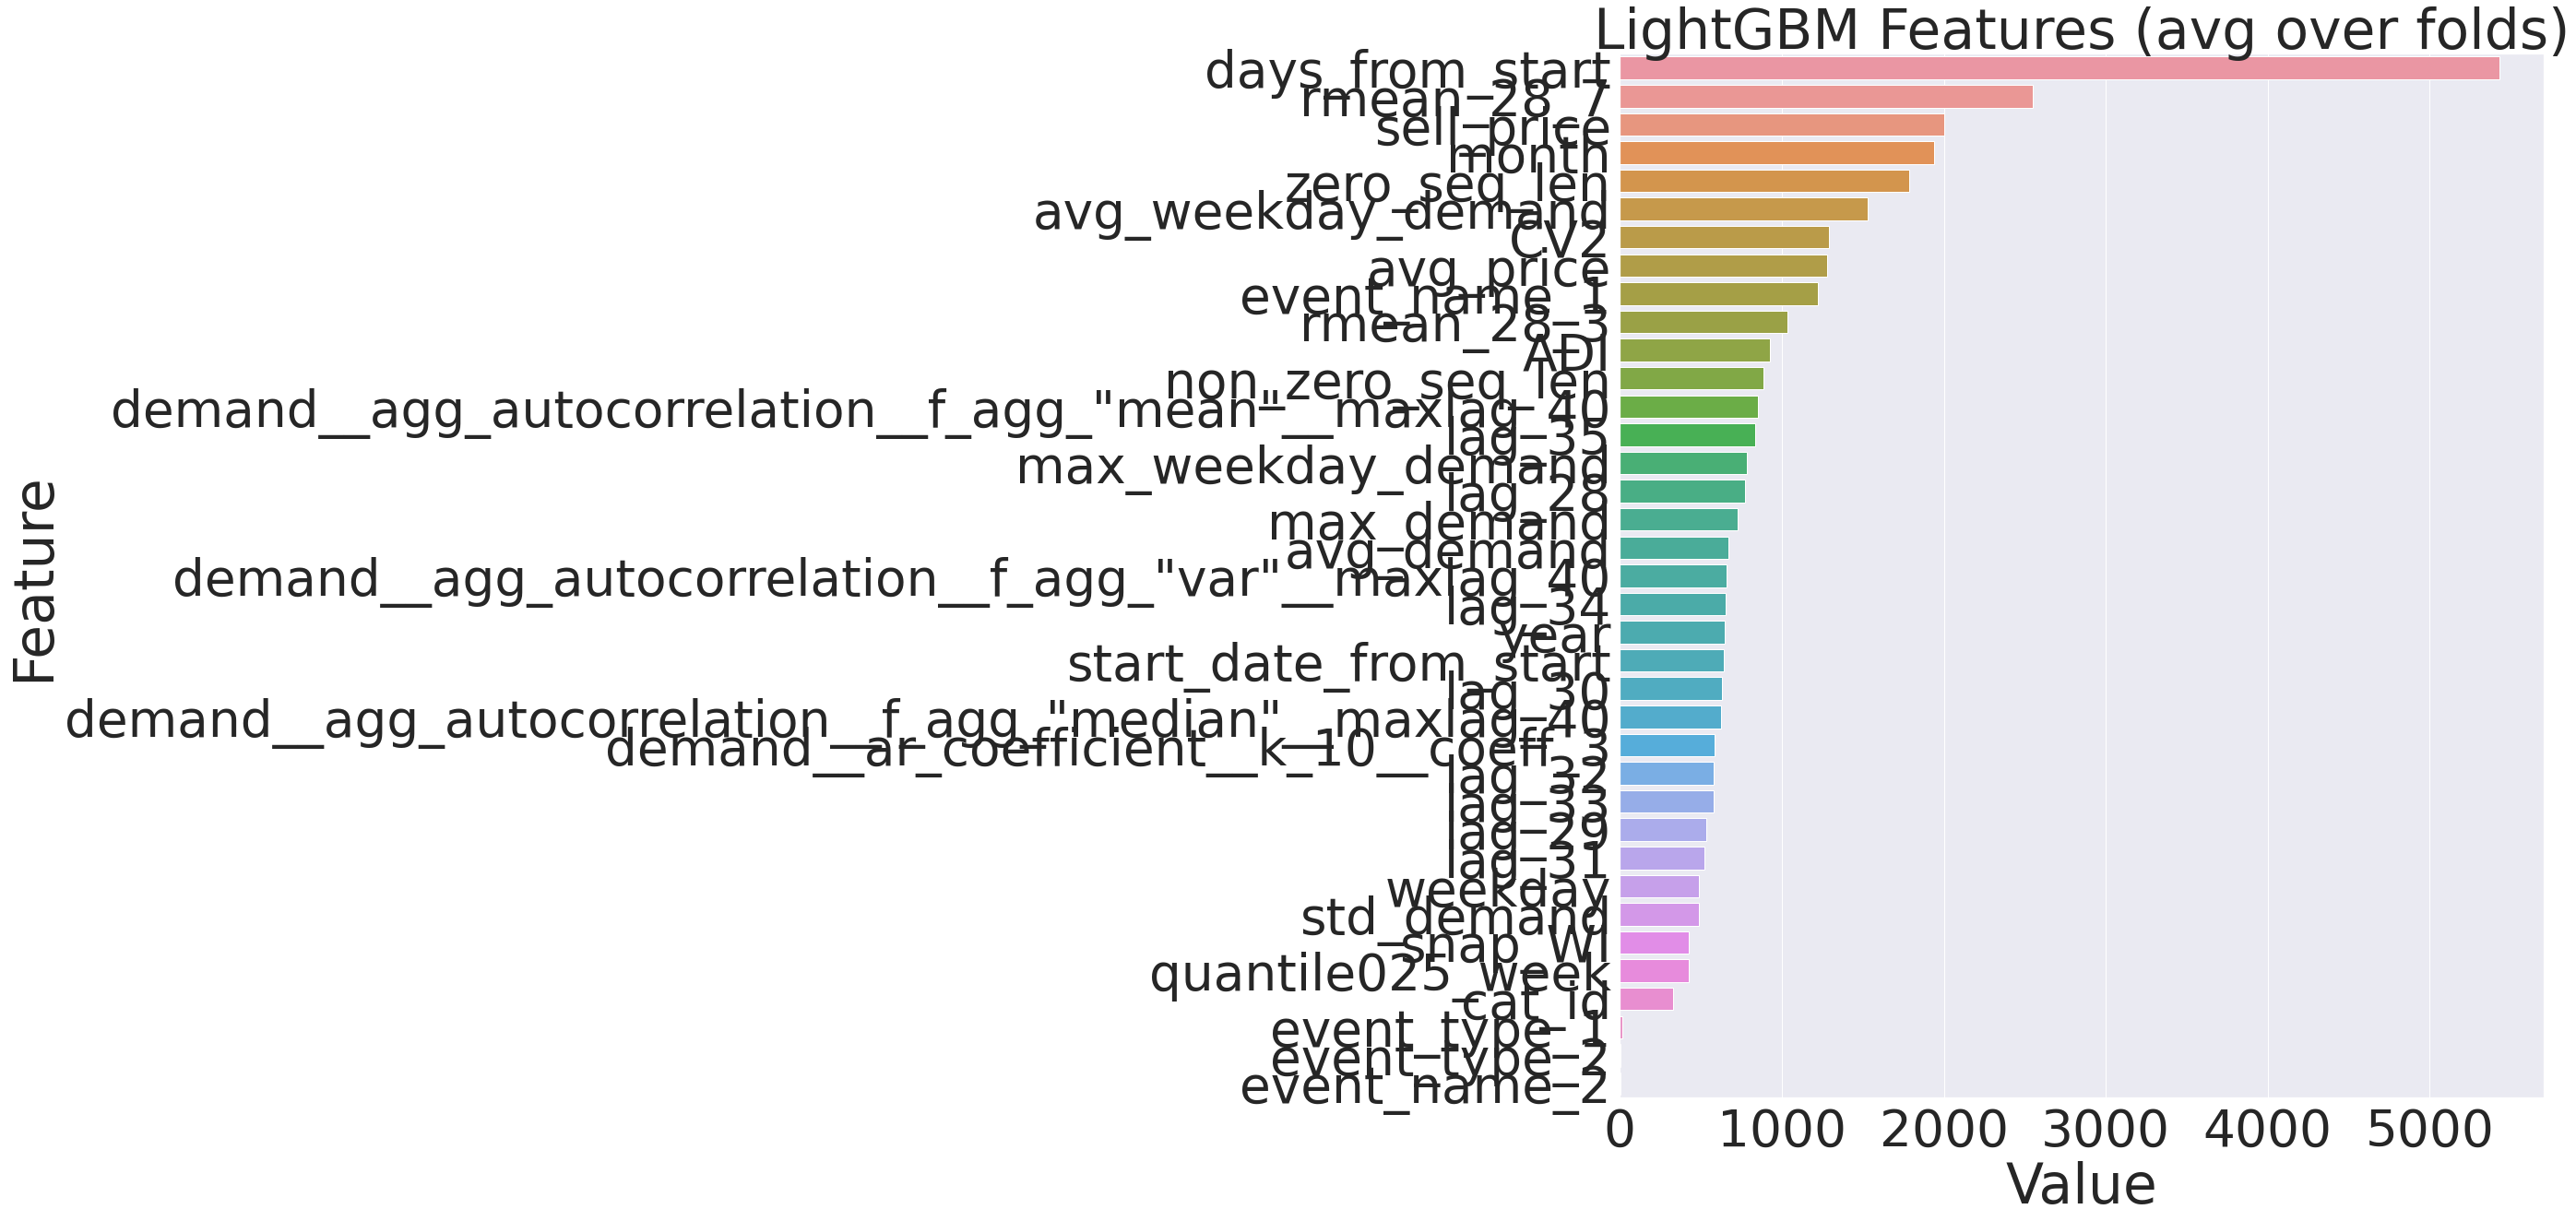

In [15]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(model, X_train[features], 40)

In [16]:
feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X_train[features].columns})
feature_imp.sort_values(by = 'Value')

,Value,Feature
6,3,event_name_2
7,4,event_type_2
4,16,event_type_1
0,327,cat_id
33,424,quantile025_week
36,425,snap_WI
26,489,std_demand
1,490,weekday
14,520,lag_31
12,534,lag_29


In [17]:
feature_imp.shape

(37, 2)

In [18]:
len(features)

37

In [19]:
np.mean(np.abs(pred_true['pred'] - pred_true['true']) )

1.0451944832176778

In [0]:
validation = validation.set_index('id')
validation = validation.reindex(index=validation_csv['id'])
validation = validation.reset_index()

In [21]:
validation

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.686490,0.728602,0.522035,0.431877,0.584437,0.813321,0.665939,0.522333,0.739203,0.608178,0.560488,0.773111,1.110236,0.783845,0.809822,0.829367,0.554291,0.482872,0.618273,0.991785,0.772063,0.614116,0.721974,0.599762,0.574988,0.747196,1.035050,0.796675
1,HOBBIES_1_002_CA_1_validation,0.296028,0.291717,0.309501,0.344199,0.339742,0.431190,0.335844,0.207668,0.186811,0.194077,0.203575,0.222296,0.277079,0.194255,0.187886,0.186811,0.187961,0.206099,0.215290,0.268869,0.221965,0.182373,0.180924,0.261401,0.296418,0.314022,0.371114,0.312404
2,HOBBIES_1_003_CA_1_validation,0.302631,0.302032,0.288042,0.315642,0.373035,0.434745,0.378658,0.297597,0.318402,0.283359,0.338377,0.405225,0.613804,0.326545,0.280175,0.298023,0.312559,0.363129,0.444011,0.697041,0.489033,0.371442,0.399149,0.391854,0.434355,0.515982,0.748521,0.498830
3,HOBBIES_1_004_CA_1_validation,1.968911,1.437797,1.370796,1.498687,1.578475,2.479903,2.758989,1.375390,1.257511,1.240097,1.417563,1.668199,2.704310,2.449986,1.893843,1.482373,1.380607,1.548419,1.677863,2.349303,2.843610,1.645635,1.321710,1.264195,1.402607,1.604244,2.984136,3.449826
4,HOBBIES_1_005_CA_1_validation,0.873263,0.737341,0.906839,0.972231,1.074276,1.525735,1.588611,1.146835,1.061497,1.091459,0.926666,1.006831,1.466645,1.054339,0.932169,0.834868,0.878183,0.864518,1.052408,1.463185,1.388443,0.892169,0.802697,0.907341,0.941844,1.106607,1.542928,1.570167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0.279930,0.244652,0.248454,0.237894,0.268868,0.281495,0.306378,0.356657,0.313272,0.245438,0.291106,0.334399,0.277170,0.321040,0.641964,0.458148,0.551576,0.464696,0.568494,0.717931,0.800554,0.585361,0.404301,0.411808,0.462457,0.511563,0.471244,0.578967
30486,FOODS_3_824_WI_3_validation,0.197647,0.178995,0.182523,0.183221,0.172048,0.344363,0.490697,0.582700,0.486444,0.423104,0.439018,0.410179,0.459012,0.577615,0.605775,0.418083,0.498201,0.493028,0.362150,0.491502,0.577136,0.408471,0.262506,0.180213,0.180901,0.169871,0.345116,0.435828
30487,FOODS_3_825_WI_3_validation,0.854063,0.694338,0.656209,0.587382,0.729881,0.807840,0.840548,1.059435,0.942237,0.885940,1.042482,1.188448,1.223436,1.320622,1.644815,1.045006,1.169225,0.946721,0.985597,1.441261,1.318536,0.939153,0.725242,0.737735,0.721241,0.824033,0.913239,0.844361
30488,FOODS_3_826_WI_3_validation,1.051059,1.118288,0.907701,0.798501,0.761907,0.991430,0.998790,0.843271,0.966408,0.692325,0.759514,0.765302,0.989676,1.163778,1.064671,0.940419,0.854541,0.854530,0.709391,1.064405,1.169097,0.733881,0.797075,0.670734,0.589355,0.630443,0.926447,1.178803


In [0]:
final = pd.concat([validation, evaluation])

In [0]:
submission_folder = '/content/drive/My Drive/Kaggle_M5/04_submissions/'
final.to_csv(submission_folder  + 'submission-by_store.csv', index = False)